[Reference](https://medium.com/analytics-vidhya/building-a-recommendation-system-using-word2vec-a-unique-tutorial-with-case-study-in-python-f02357fd2486)

In [3]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [4]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
!pwd
os.chdir('gdrive/My Drive/Colab Notebooks')
!pwd

Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Colab Notebooks


In [5]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.shape

(541909, 8)

In [7]:
# check for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
# remove missing values
df.dropna(inplace=True)

In [9]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [10]:
df['StockCode']= df['StockCode'].astype(str)

In [11]:
customers = df["CustomerID"].unique().tolist()

In [12]:
customers

[17850.0,
 13047.0,
 12583.0,
 13748.0,
 15100.0,
 15291.0,
 14688.0,
 17809.0,
 15311.0,
 14527.0,
 16098.0,
 18074.0,
 17420.0,
 16029.0,
 16250.0,
 12431.0,
 17511.0,
 17548.0,
 13705.0,
 13747.0,
 13408.0,
 13767.0,
 17924.0,
 13448.0,
 15862.0,
 15513.0,
 12791.0,
 16218.0,
 14045.0,
 14307.0,
 17908.0,
 17920.0,
 12838.0,
 13255.0,
 16583.0,
 18085.0,
 13758.0,
 13694.0,
 15983.0,
 14849.0,
 17968.0,
 16210.0,
 17897.0,
 17377.0,
 16552.0,
 17181.0,
 17951.0,
 14729.0,
 12748.0,
 15012.0,
 12868.0,
 17572.0,
 14078.0,
 14001.0,
 12662.0,
 15525.0,
 14237.0,
 17905.0,
 15485.0,
 12433.0,
 16955.0,
 15350.0,
 15605.0,
 18144.0,
 15922.0,
 14594.0,
 15165.0,
 14911.0,
 16456.0,
 17841.0,
 12472.0,
 17346.0,
 17643.0,
 17873.0,
 13093.0,
 12921.0,
 13468.0,
 17760.0,
 16928.0,
 16048.0,
 16274.0,
 14496.0,
 14696.0,
 16539.0,
 17025.0,
 13777.0,
 17690.0,
 12947.0,
 17460.0,
 18229.0,
 14142.0,
 17069.0,
 13065.0,
 14606.0,
 16835.0,
 15235.0,
 13576.0,
 18011.0,
 13090.0,
 15694.0,


In [14]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

In [15]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:04<00:00, 830.67it/s]


In [16]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 1099.58it/s]


In [17]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3666609, 3703300)

In [18]:
model.init_sims(replace=True)

In [19]:
print(model)

Word2Vec(vocab=3177, size=100, alpha=0.03)


In [20]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3177, 100)

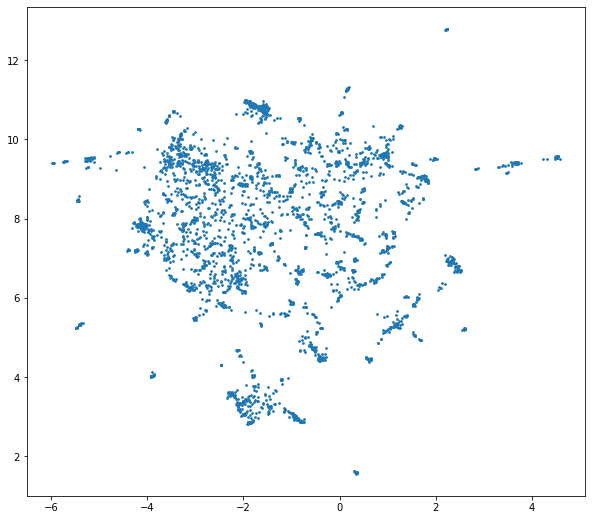

In [21]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [22]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [23]:
# test the dictionary 
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

In [24]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms        

In [25]:
similar_products(model['90019A'])

[('AMBER DROP EARRINGS W LONG BEADS', 0.8399737477302551),
 ('BLUE MURANO TWIST BRACELET', 0.8242725729942322),
 ('RASPBERRY ANT COPPER FLOWER NECKLAC', 0.8081694841384888),
 ('ANT COPPER RED BOUDICCA BRACELET', 0.8003727197647095),
 ('SILVER M.O.P ORBIT DROP EARRINGS', 0.7952064275741577),
 ('PINK BOUDICCA LARGE BRACELET', 0.7937248349189758)]

In [26]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [27]:
len(purchases_val[0])

90

In [28]:
aggregate_vectors(purchases_val[0]).shape

(100,)

In [29]:
similar_products(aggregate_vectors(purchases_val[0]))

[('LUNCH BAG PINK POLKADOT', 0.7631908059120178),
 ('LUNCH BAG  BLACK SKULL.', 0.744490385055542),
 ('LUNCH BAG RED RETROSPOT', 0.7437456846237183),
 ('LUNCH BAG SUKI DESIGN ', 0.716526985168457),
 ('LUNCH BAG SPACEBOY DESIGN ', 0.7099560499191284),
 ('LUNCH BAG WOODLAND', 0.6942969560623169)]

In [30]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('LUNCH BAG RED RETROSPOT', 0.6591967344284058),
 ('LUNCH BAG VINTAGE DOILY ', 0.6504637002944946),
 ('CREAM HANGING HEART T-LIGHT HOLDER', 0.6422110795974731),
 ('HEART OF WICKER SMALL', 0.6348291635513306),
 ('LUNCH BAG  BLACK SKULL.', 0.6338427066802979),
 ('LUNCH BAG SPACEBOY DESIGN ', 0.6265304684638977)]